# PCA (Eigenfaces) 实验
本实验通过 Olivetti 人脸数据集演示经典 PCA（Eigenfaces）流程，包括数据预处理、协方差矩阵求解、特征向量/特征值分析，以及基于主成分的人脸重构效果。

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces


In [ ]:
# 配置 matplotlib 支持中文显示
plt.rcParams["font.sans-serif"] = [
    "Sarasa Gothic SC",
    "Noto Sans CJK SC",
    "Microsoft YaHei",
    "WenQuanYi Micro Hei",
]
plt.rcParams["axes.unicode_minus"] = False


In [ ]:
# 设置数据目录，若不存在会自动创建
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)
faces = fetch_olivetti_faces(data_home=data_dir, shuffle=True, random_state=42)
images = faces.images
X = faces.data
n_samples, n_features = X.shape
image_shape = images[0].shape
print(f"样本数: {n_samples}, 特征数: {n_features}, 单张图片尺寸: {image_shape}")


样本数: 400, 特征数: 4096, 单张图片尺寸: (64, 64)


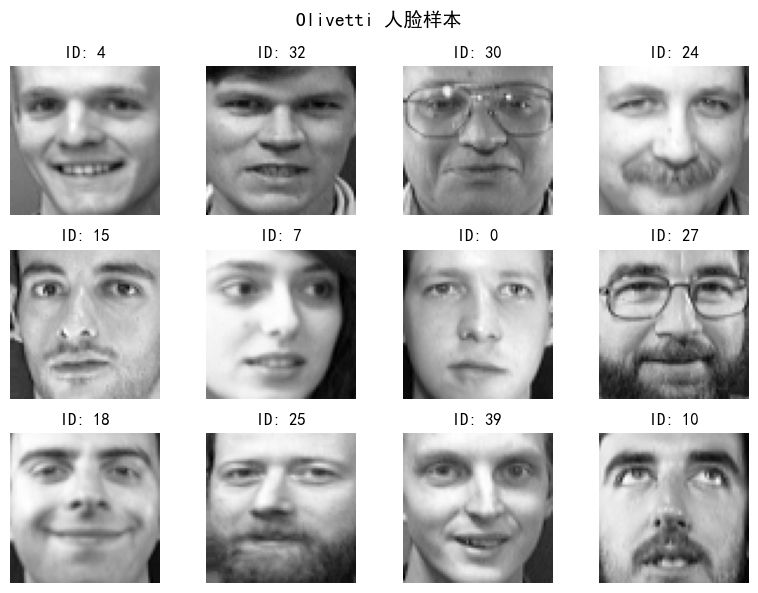

In [ ]:
# 随机展示部分人脸样本
rng = np.random.default_rng(0)
sample_indices = rng.choice(n_samples, size=12, replace=False)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
for ax, idx in zip(axes.ravel(), sample_indices):
    ax.imshow(images[idx], cmap="gray")
    ax.set_title(f"ID: {faces.target[idx]}")
    ax.axis("off")
fig.suptitle("Olivetti 人脸样本", fontsize=14)
plt.tight_layout()
plt.show()


## PCA 理论回顾
- 将每张人脸展开为高维向量，计算样本均值并中心化数据；
- 构造协方差矩阵，求解其特征值与特征向量；
- 选取前 $k$ 个主成分，形成特征脸（Eigenfaces）；
- 使用选定的主成分重构或识别新的样本。

In [ ]:
# 手动计算协方差矩阵并执行 PCA
mean_face = X.mean(axis=0)
X_centered = X - mean_face
cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)
print(f"协方差矩阵形状: {cov_matrix.shape}")
eigvals, eigvecs = np.linalg.eigh(cov_matrix)
sort_idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_idx]
eigvecs = eigvecs[:, sort_idx]
print("前 10 个特征值:", np.round(eigvals[:10], 4))


协方差矩阵形状: (4096, 4096)
前 10 个特征值: [18.8402 11.0718  6.3046  3.9546  2.856   2.4977  1.9201  1.6112  1.5492
  1.323 ]
前 10 个特征值: [18.8402 11.0718  6.3046  3.9546  2.856   2.4977  1.9201  1.6112  1.5492
  1.323 ]


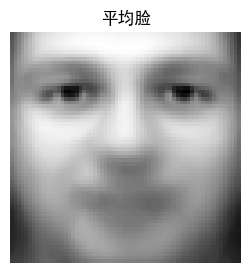

In [ ]:
plt.figure(figsize=(3, 3))
plt.imshow(mean_face.reshape(image_shape), cmap="gray")
plt.title("平均脸")
plt.axis("off")
plt.show()


In [ ]:
# 展示协方差矩阵前 6x6 的数值以了解结构
preview_size = 6
cov_preview = cov_matrix[:preview_size, :preview_size]
print("协方差矩阵前 6x6 子块:")
print(np.round(cov_preview, 4))


协方差矩阵前 6x6 子块:
[[0.0327 0.0323 0.0287 0.0245 0.0208 0.0179]
 [0.0323 0.0359 0.0341 0.0295 0.0249 0.0217]
 [0.0287 0.0341 0.0379 0.0353 0.0304 0.0263]
 [0.0245 0.0295 0.0353 0.0374 0.0342 0.0297]
 [0.0208 0.0249 0.0304 0.0342 0.0356 0.0322]
 [0.0179 0.0217 0.0263 0.0297 0.0322 0.0319]]


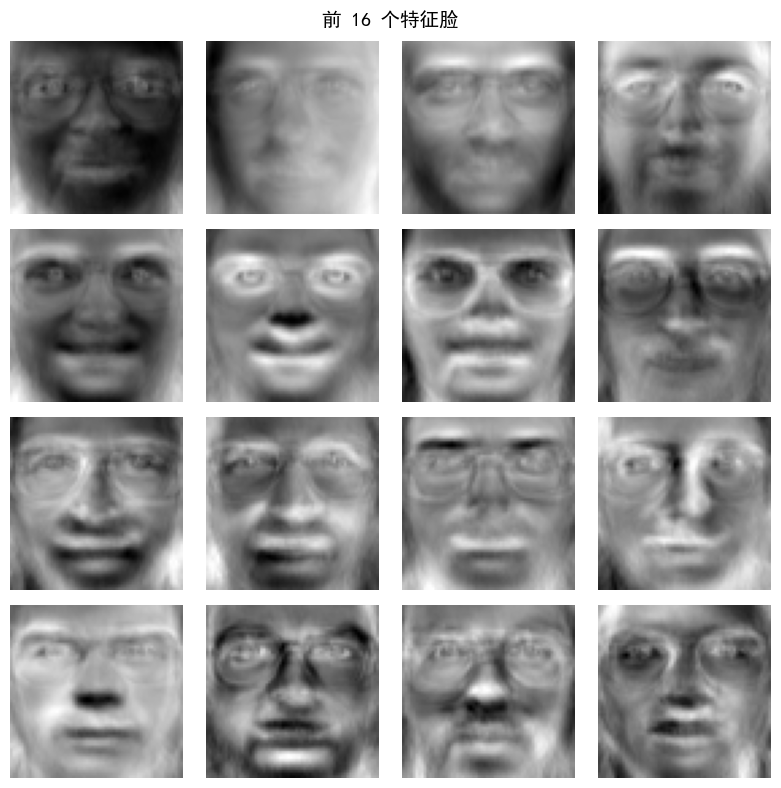

In [ ]:
# 将前几个特征向量可视化为特征脸
num_eigenfaces = 16
eigenfaces = eigvecs[:, :num_eigenfaces].T.reshape((num_eigenfaces, *image_shape))
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for ax, eig_face in zip(axes.ravel(), eigenfaces):
    ax.imshow(eig_face, cmap="gray")
    ax.axis("off")
fig.suptitle("前 16 个特征脸", fontsize=14)
plt.tight_layout()
plt.show()


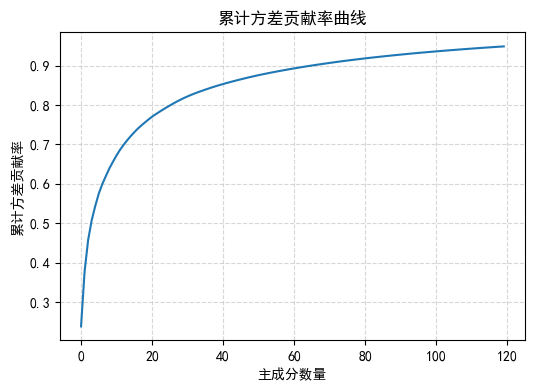

In [ ]:
# 计算累计方差贡献率
explained_variance_ratio = eigvals / eigvals.sum()
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(6, 4))
plt.plot(cumulative_variance[:120])
plt.xlabel("主成分数量")
plt.ylabel("累计方差贡献率")
plt.title("累计方差贡献率曲线")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


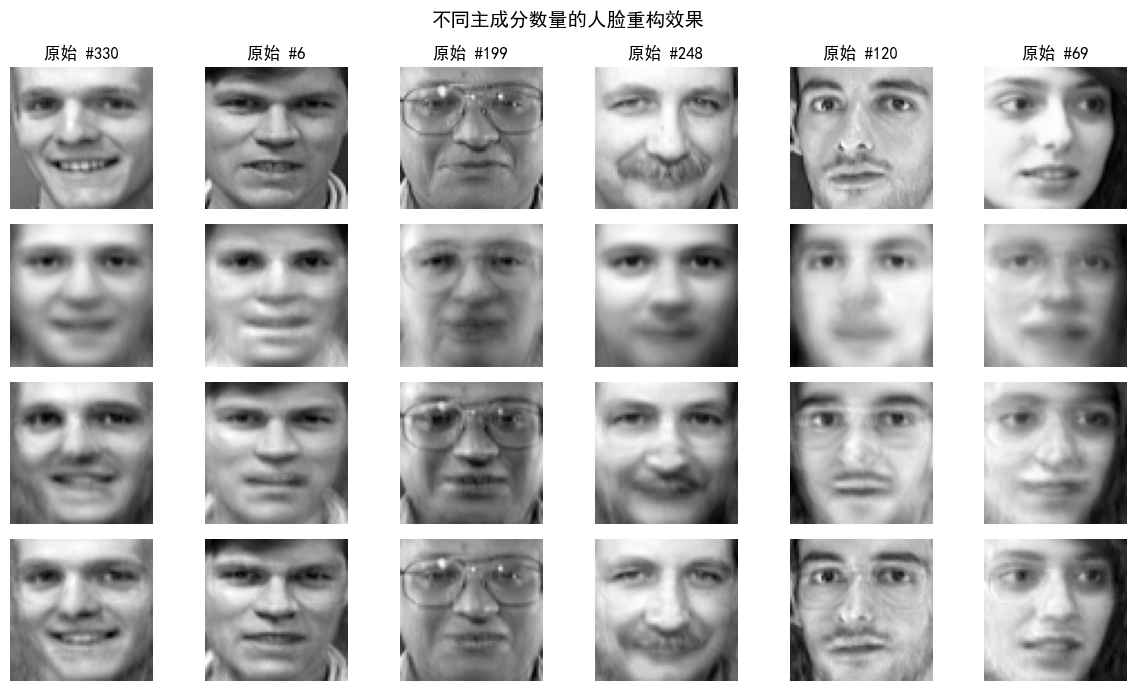

In [ ]:
# 使用不同数量的主成分重构人脸
k_values = [10, 40, 120]
fig, axes = plt.subplots(len(k_values) + 1, 6, figsize=(12, 7))
selected_indices = sample_indices[:6]
for col, idx in enumerate(selected_indices):
    axes[0, col].imshow(images[idx], cmap="gray")
    axes[0, col].set_title(f"原始 #{idx}")
    axes[0, col].axis("off")
for row, k in enumerate(k_values, start=1):
    basis = eigvecs[:, :k]
    for col, idx in enumerate(selected_indices):
        coeff = X_centered[idx] @ basis
        reconstruction = coeff @ basis.T + mean_face
        axes[row, col].imshow(reconstruction.reshape(image_shape), cmap="gray")
        if col == 0:
            axes[row, col].set_ylabel(f"k={k}", rotation=0, labelpad=30)
        axes[row, col].axis("off")
fig.suptitle("不同主成分数量的人脸重构效果", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# 使用 PCA 特征进行简单的人脸分类实验（1-NN）
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

k_feature = 80
pca_basis = eigvecs[:, :k_feature]
X_proj = X_centered @ pca_basis
X_train, X_test, y_train, y_test, _img_train, img_test = train_test_split(
    X_proj,
    faces.target,
    images,
    test_size=0.25,
    random_state=42,
    stratify=faces.target,
)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
accuracy = knn.score(X_test, y_test)
print(f"使用前 {k_feature} 个主成分的 1-NN 分类准确率: {accuracy:.3f}")


使用前 80 个主成分的 1-NN 分类准确率: 0.940


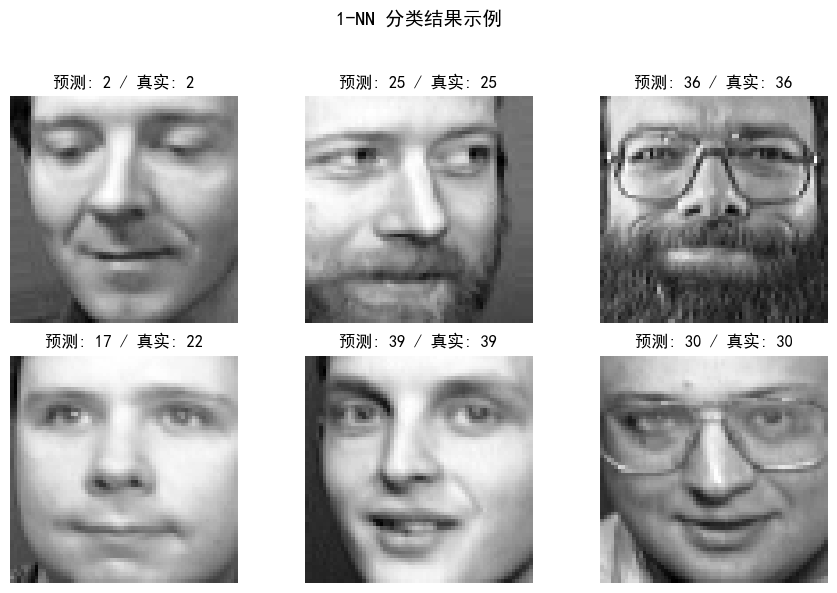

In [ ]:
display_rng = np.random.default_rng(1)
sample_count = 6
sample_indices = display_rng.choice(len(X_test), size=sample_count, replace=False)
sample_predictions = knn.predict(X_test[sample_indices])

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for ax, idx, pred in zip(axes.ravel(), sample_indices, sample_predictions):
    ax.imshow(img_test[idx], cmap="gray")
    ax.set_title(f"预测: {pred} / 真实: {y_test[idx]}")
    ax.axis("off")
fig.suptitle("1-NN 分类结果示例", fontsize=14)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


> 通过上述实验，我们手动实现了 PCA（Eigenfaces）的关键步骤，并验证了其在降维与分类任务中的有效性。